In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import optimize
from scipy.interpolate import interp1d

import rebound
import radvel

import corner
import emcee

from multiprocessing import Pool, get_context
from tqdm import tqdm

from astropy.io import fits

# ESPRESSO Spectra

In [2]:
# Example ESPRESSO spectrum

hdu = fits.open('ESPRESSO_spectra/ESPRE.2023-04-08T07:04:03.704_S1D_SKYSUB_A.fits')
wl, flux = hdu[1].data['wavelength'], hdu[1].data['flux']

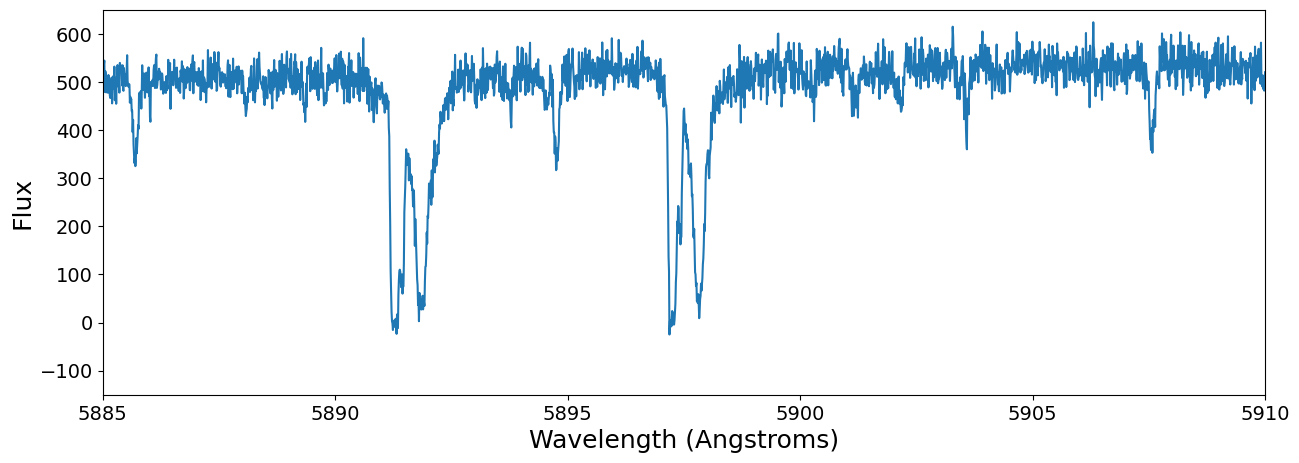

In [3]:
spectrum_fig = plt.figure(figsize = (15, 5))
plt.plot(wl, flux)
plt.xlim(5885, 5910)
plt.ylim(-150, 650)
plt.xlabel('Wavelength (Angstroms)', size = 18)
plt.ylabel('Flux', size = 18)
plt.tick_params(labelsize = 14)

# Derived Radial Velocities

In [4]:
# HIRES, FEROS, TRES, and ESPRESSO data

combine_tab = pd.read_csv('all_data.csv')
combine_tab.head()

HJD      RV  RV Error Instrument
0  2.459792e+06  131.90       0.1      HIRES
1  2.459824e+06   53.76       0.1      HIRES
2  2.459825e+06   51.18       0.1      HIRES
3  2.459827e+06   46.59       0.1      HIRES
4  2.459834e+06   33.23       0.1      HIRES

In [5]:
jds_BH1 = combine_tab['HJD'].values
rvs_BH1 = combine_tab['RV'].values
rv_errs_BH1 = combine_tab['RV Error'].values
rv_names_BH1 = combine_tab['Instrument'].values

In [6]:
def update_offsets(RVs, labels, hires_offset, feros_offset, tres_offset):
    """Apply instrumental RV offsets with respect to ESPRESSO."""
    shift_RVs = []
    for i in range(len(labels)):
        if labels[i] == 'HIRES':
            shift_RVs.append(RVs[i] + hires_offset)
        elif labels[i] == 'FEROS':
            shift_RVs.append(RVs[i] + feros_offset)
        elif labels[i] == 'TRES':
             shift_RVs.append(RVs[i] + tres_offset)
        else:
            shift_RVs.append(RVs[i])
    shift_RVs = np.array(shift_RVs)
    return shift_RVs

In [7]:
# Additional RV data from other lower-resolution spectrographs

jds_add = np.array([2459767.6226, 2459795.6461, 2459796.4995, 2459798.8399, 2459805.5101,
                    2459808.7388, 2459818.787 , 2459829.5373, 2459838.7208, 2459845.5069,
                    2459855.5012, 2459868.5128, 2459877.6978])

rvs_add = np.array([63.8, 141.4, 142.7, 140.6, 127.7, 118., 67.8, 42.1, 27.5, 19.4,
                    14.2, 9.3, 10.5])  

rv_errs_add = np.array([3., 3., 3., 4., 1., 4., 4., 3., 4., 1., 1., 1., 1.5])

rv_names_add = np.array(['MagE', 'MagE', 'MagE', 'GMOS', 'XSHOOTER', 'GMOS', 'GMOS', 'MagE',
                         'GMOS', 'XSHOOTER', 'XSHOOTER', 'XSHOOTER', 'ESI'])

add_df = pd.DataFrame({'HJD' : jds_add, 'RV' : rvs_add, 'RV Error' : rv_errs_add, 'Instrument' : rv_names_add})

full_tab = pd.concat([combine_tab, add_df], ignore_index = True)
display(full_tab.tail())

HJD    RV  RV Error Instrument
123  2.459839e+06  27.5       4.0       GMOS
124  2.459846e+06  19.4       1.0   XSHOOTER
125  2.459856e+06  14.2       1.0   XSHOOTER
126  2.459869e+06   9.3       1.0   XSHOOTER
127  2.459878e+06  10.5       1.5        ESI

In [8]:
# Load in all RV data

full_jds_BH1 = full_tab['HJD'].values
full_rvs_BH1 = full_tab['RV'].values
full_rv_errs_BH1 = full_tab['RV Error'].values
full_rv_names_BH1 = full_tab['Instrument'].values

# Astrometric Data

In [9]:
# Vector of best-fit parameters and correlation matrix from Gaia DR3
# ra, dec, parallax, pmra, pmdec, a_thiele_innes, b_thiele_innes, f_thiele_innes, g_thiele_innes, 
# ecc, period, t_peri

mu_vec_BH1 = np.array([262.171208162297, -0.5810920153840334, 2.0954515888832432, -7.702050443675317, 
                       -25.85042074524512, -0.262289119199277, 2.9291159041806485, 1.5248071482113947,
                       0.5343685858549198, 0.48893589298452034, 185.7656578920495, -12.024680365644883])

err_vec_BH1 = np.array([0.49589708, 0.15092158, 0.01745574, 0.02040691, 0.02699432, 0.16984475, 
                        0.17521776, 0.15387644, 0.54653114, 0.074341,0.30688563, 6.34896183])

corr_vec_BH1 = np.array([-0.9385065 , -0.10964689,  0.09768217,  0.02599761, -0.09885585,
                        -0.04858593,  0.04631094, -0.18919176,  0.12997928,  0.08754877,
                        -0.7026825 ,  0.7199984 , -0.1333831 , -0.16456777,  0.06737773,
                         0.976118  , -0.90516096, -0.0790209 , -0.0389514 ,  0.14850111,
                        -0.64331377,  0.7340439 , -0.7446727 , -0.32354277, -0.02299099,
                         0.10600532, -0.12226893,  0.70452565,  0.31863543, -0.2744563 ,
                         0.2560132 ,  0.1476755 , -0.23248082, -0.85903525,  0.25882402,
                        -0.35804698,  0.9656088 , -0.9219766 , -0.2000572 ,  0.05323359,
                         0.00881674, -0.5612588 ,  0.9152694 ,  0.8657674 ,  0.1358042 ,
                        -0.01977275,  0.06291951, -0.08401399,  0.08238114, -0.81962156,
                        -0.07304911, -0.14815669,  0.03363582,  0.13756153,  0.0689249 ,
                        -0.21668243,  0.16537377, -0.2642203 , -0.15781169,  0.33261746,
                         0.7964632 , -0.14971647,  0.4369154 , -0.98625296, -0.0418497 ,
                        -0.25472474])

In [10]:
def convert_corr_to_cov(err_vec, corr_vec):
    """Generate covariance matrix from correlation matrix."""
    Nparam = len(err_vec)
    triangle_nums = (np.arange(1, Nparam) * (np.arange(1, Nparam) - 1) // 2)
    cov_mat = []
    count = 0
    for i, sig_x in enumerate(err_vec):
        row = []
        for j, sig_y in enumerate(err_vec):
            if i == j:
                row.append(err_vec[i] ** 2)
            elif j < i:
                row.append(cov_mat[j][i])
            else:
                idx = triangle_nums[j - 1] + i
                row.append(corr_vec[idx] * sig_x * sig_y)
        cov_mat.append(row)
    return np.array(cov_mat)

cov_mat_BH1 = convert_corr_to_cov(err_vec_BH1, corr_vec_BH1)

mu_vec_BH1_short =  mu_vec_BH1[5:]
cov_mat_BH1_short = np.delete(cov_mat_BH1, [0, 1, 2, 3, 4], axis = 0)
cov_mat_BH1_short = np.delete(cov_mat_BH1_short, [0, 1, 2, 3, 4], axis = 1)

In [11]:
def get_a0_mas(period, m1, m2, parallax):
    """
    Predicts a0 (photocenter semi-major axis) in milliarcsec, assuming a dark companion
    period: float, days
    m1: float, Msun, (mass of luminous star)
    m2: float, Msun, (mass of companion)
    parallax: float, milliarcsec
    """
    G = 6.6743e-11
    Msun = 1.98840987069805e+30
    AU = 1.4959787e+11
    a_au = (((period * 86400) ** 2 * G * (m1 * Msun + m2 * Msun) / (4 * np.pi ** 2)) ** (1/3.)) / AU
    a_mas = a_au * parallax
    q = m2 / m1
    a0_mas = a_mas * q / (1 + q)
    return a0_mas

In [12]:
jd_ref = 2460000
jd_ref_gaia = 2457389

m1_obs, m1_err = 0.93, 0.05


def lnL_with_covariance(y_vec, mu_vec, Sigma_mat):
    """Calculates the likelihood of a vector y_vec, given a multivariate Gaussian likelihood characterized by 
    a mean mu_vec and a covariance matrix Sigma_mat."""
    prefactor = -0.5 * (np.log(np.linalg.det(Sigma_mat)) + len(mu_vec) * np.log(2 * np.pi))
    exponent = -0.5 * np.dot((y_vec - mu_vec).T, np.dot(np.linalg.inv(Sigma_mat), y_vec - mu_vec))
    return prefactor + exponent


def update_log_likelihood(theta, ll):
    """Calculate astrometric term of log likelihood."""
    (period, ecc, inc_deg, omega_deg, w_deg, t_peri, v_com, h_offset, f_offset, t_offset, M_BH, M_star) = theta 
    inc, omega, w = inc_deg * np.pi/180, omega_deg * np.pi/180, w_deg * np.pi/180
    a0_mas = get_a0_mas(period = period, m1 = M_star, m2 = M_BH, parallax = 2.0954515888832432)
    A_pred = a0_mas * (np.cos(w) * np.cos(omega) - np.sin(w) * np.sin(omega) * np.cos(inc))
    B_pred = a0_mas * (np.cos(w) * np.sin(omega) + np.sin(w) * np.cos(omega) * np.cos(inc))
    F_pred = -a0_mas * (np.sin(w) * np.cos(omega) + np.cos(w) * np.sin(omega) * np.cos(inc))
    G_pred = -a0_mas * (np.sin(w) * np.sin(omega) - np.cos(w) * np.cos(omega) * np.cos(inc))
    num_cycles = np.floor((jd_ref - jd_ref_gaia) / period)
    t_peri_gaia = t_peri + jd_ref - jd_ref_gaia - num_cycles * period
    y_vec = np.array([A_pred, B_pred, F_pred, G_pred, ecc, period, t_peri_gaia])
    ll += lnL_with_covariance(y_vec = y_vec, mu_vec = mu_vec_BH1_short, Sigma_mat = cov_mat_BH1_short)
    return ll

# Two-Body Keplerian Model

In [13]:
# Predict RVs assuming single BH and Keplerian orbit

def fsolve_newton(Mi, ecc, xtol = 1e-10):
    """
    Numerically solve with newton's method.
    Mi: float, 2 * pi / P * (t - T_p)
    ecc: float, eccentricity
    xtol: float, tolerance
    """
    eps = 1
    EE = Mi + ecc * np.sin(Mi) + ecc ** 2 / 2 * np.sin(2 * Mi) + ecc ** 3/8 * (3 * np.sin(3 * Mi) - np.sin(Mi))
    while eps > xtol:
        EE0 = EE
        EE = EE0 + (Mi + ecc * np.sin(EE0) - EE0)/(1 - ecc * np.cos(EE0))
        eps = np.abs(EE0 - EE) 
    return EE

def solve_kep_eqn(t, T_p, P, ecc):
    """
    Solve Keplers equation E - e*sin(E) = M for E.
    Here, M = 2 * pi / P * (t - T_p).
    t: array of times
    T_p: float; periastron time
    P: float, period 
    ecc: float, eccentricity
    """
    M = 2 * np.pi / P * (t - T_p)
    E = np.zeros(t.shape)
    for i, Mi in enumerate(M):
        E[i] = fsolve_newton(Mi = Mi, ecc = ecc, xtol = 1e-10)
    return E

def get_radial_velocities(t, P, T_p, ecc, K, omega, gamma):
    """
    t: array of times
    P: float, period
    T_p: float, periastron time
    ecc: float, eccentricity
    K: float, RV semi-amplitude
    omega: float, longitude of periastron (radians, not degrees)
    gamma: float, center-of-mass RV
    """
    E = solve_kep_eqn(t = t, T_p = T_p, P = P, ecc = ecc)
    f = 2 * np.arctan2(np.sqrt(1 + ecc) * np.sin(0.5 * E), np.sqrt(1 - ecc) * np.cos(0.5 * E))
    vr = K * (np.cos(f + omega) + ecc * np.cos(omega)) + gamma
    return vr

In [14]:
def get_Kstar_kms(period, inc_deg, m1, m2, ecc):
    """
    RV semi-amplitude of the luminous star
    period: float, days
    inc_deg: float, inclination in degrees
    m1: float, mass of luminous star in Msun
    m2: float, mass of companion in Msun
    ecc: float, eccentricity
    """
    G = 6.6743e-11 
    Msun = 1.98840987069805e+30
    numerator = 2 * np.pi * G * (m2 * Msun) * (m2 / (m1 + m2)) ** 2 * np.sin(inc_deg * np.pi / 180) ** 3
    denominator = period * 86400 * (1 - ecc ** 2) ** (3 / 2)
    Kstar = (numerator / denominator) ** (1 / 3)
    return Kstar / 1000 

In [15]:
def log_likelihood(theta):
    (period, ecc, inc_deg, omega_deg, w_deg, t_peri, v_com, h_offset, f_offset, t_offset, M_BH, M_star) = theta 
    inc, omega, w = inc_deg * np.pi/180, omega_deg * np.pi/180, w_deg * np.pi/180
    
    Kstar_kms = get_Kstar_kms(period = period, inc_deg = inc_deg, m1 = M_star, m2 = M_BH, ecc = ecc)
    rv_pred = get_radial_velocities(t = jds_BH1 - jd_ref, P = period, T_p = t_peri, ecc = ecc, 
                                    K = Kstar_kms, omega = w, gamma = v_com)
    rv_pred = update_offsets(rv_pred, rv_names_BH1, h_offset, f_offset, t_offset)
    
    lnL = -0.5 * np.sum((rv_pred - rvs_BH1) ** 2 / rv_errs_BH1 ** 2)
    lnL = update_log_likelihood(theta, lnL)
    
    # Gaussian prior on the mass of the luminous star
    lnL += -0.5 * (M_star - m1_obs) ** 2 / m1_err ** 2 
    
    # Flat prior on gamma to avoid walkers running to infinity
    if np.abs(v_com - 50) > 50:
        lnL += -np.inf
    
    if np.isfinite(lnL):
        return lnL
    else:
        return -np.inf

In [16]:
# Initialize emcee sampler

ndim, nwalkers = 12, 64

p0 = np.array([1.85386095e+02, 4.32289423e-01, 1.26612301e+02, 9.71086345e+01, 1.65097510e+01, 
               -1.35069296e+01, 4.83796350e+01, 8.03608883e-02, 2.25223884e-01, 5.09014030e-01, 
               9.27788894e+00, 9.66274035e-01])

p0 = np.tile(p0, (nwalkers, 1))
p0 += p0 * 1.0e-10 * np.random.normal(size = (nwalkers, ndim))

In [17]:
# Run emcee sampler

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

state = sampler.run_mcmc(p0, 5000, progress = True)
sampler.reset()

state = sampler.run_mcmc(state, 3000, progress = True)

100%|███████████████████████████████████████| 3000/3000 [03:04<00:00, 16.28it/s]


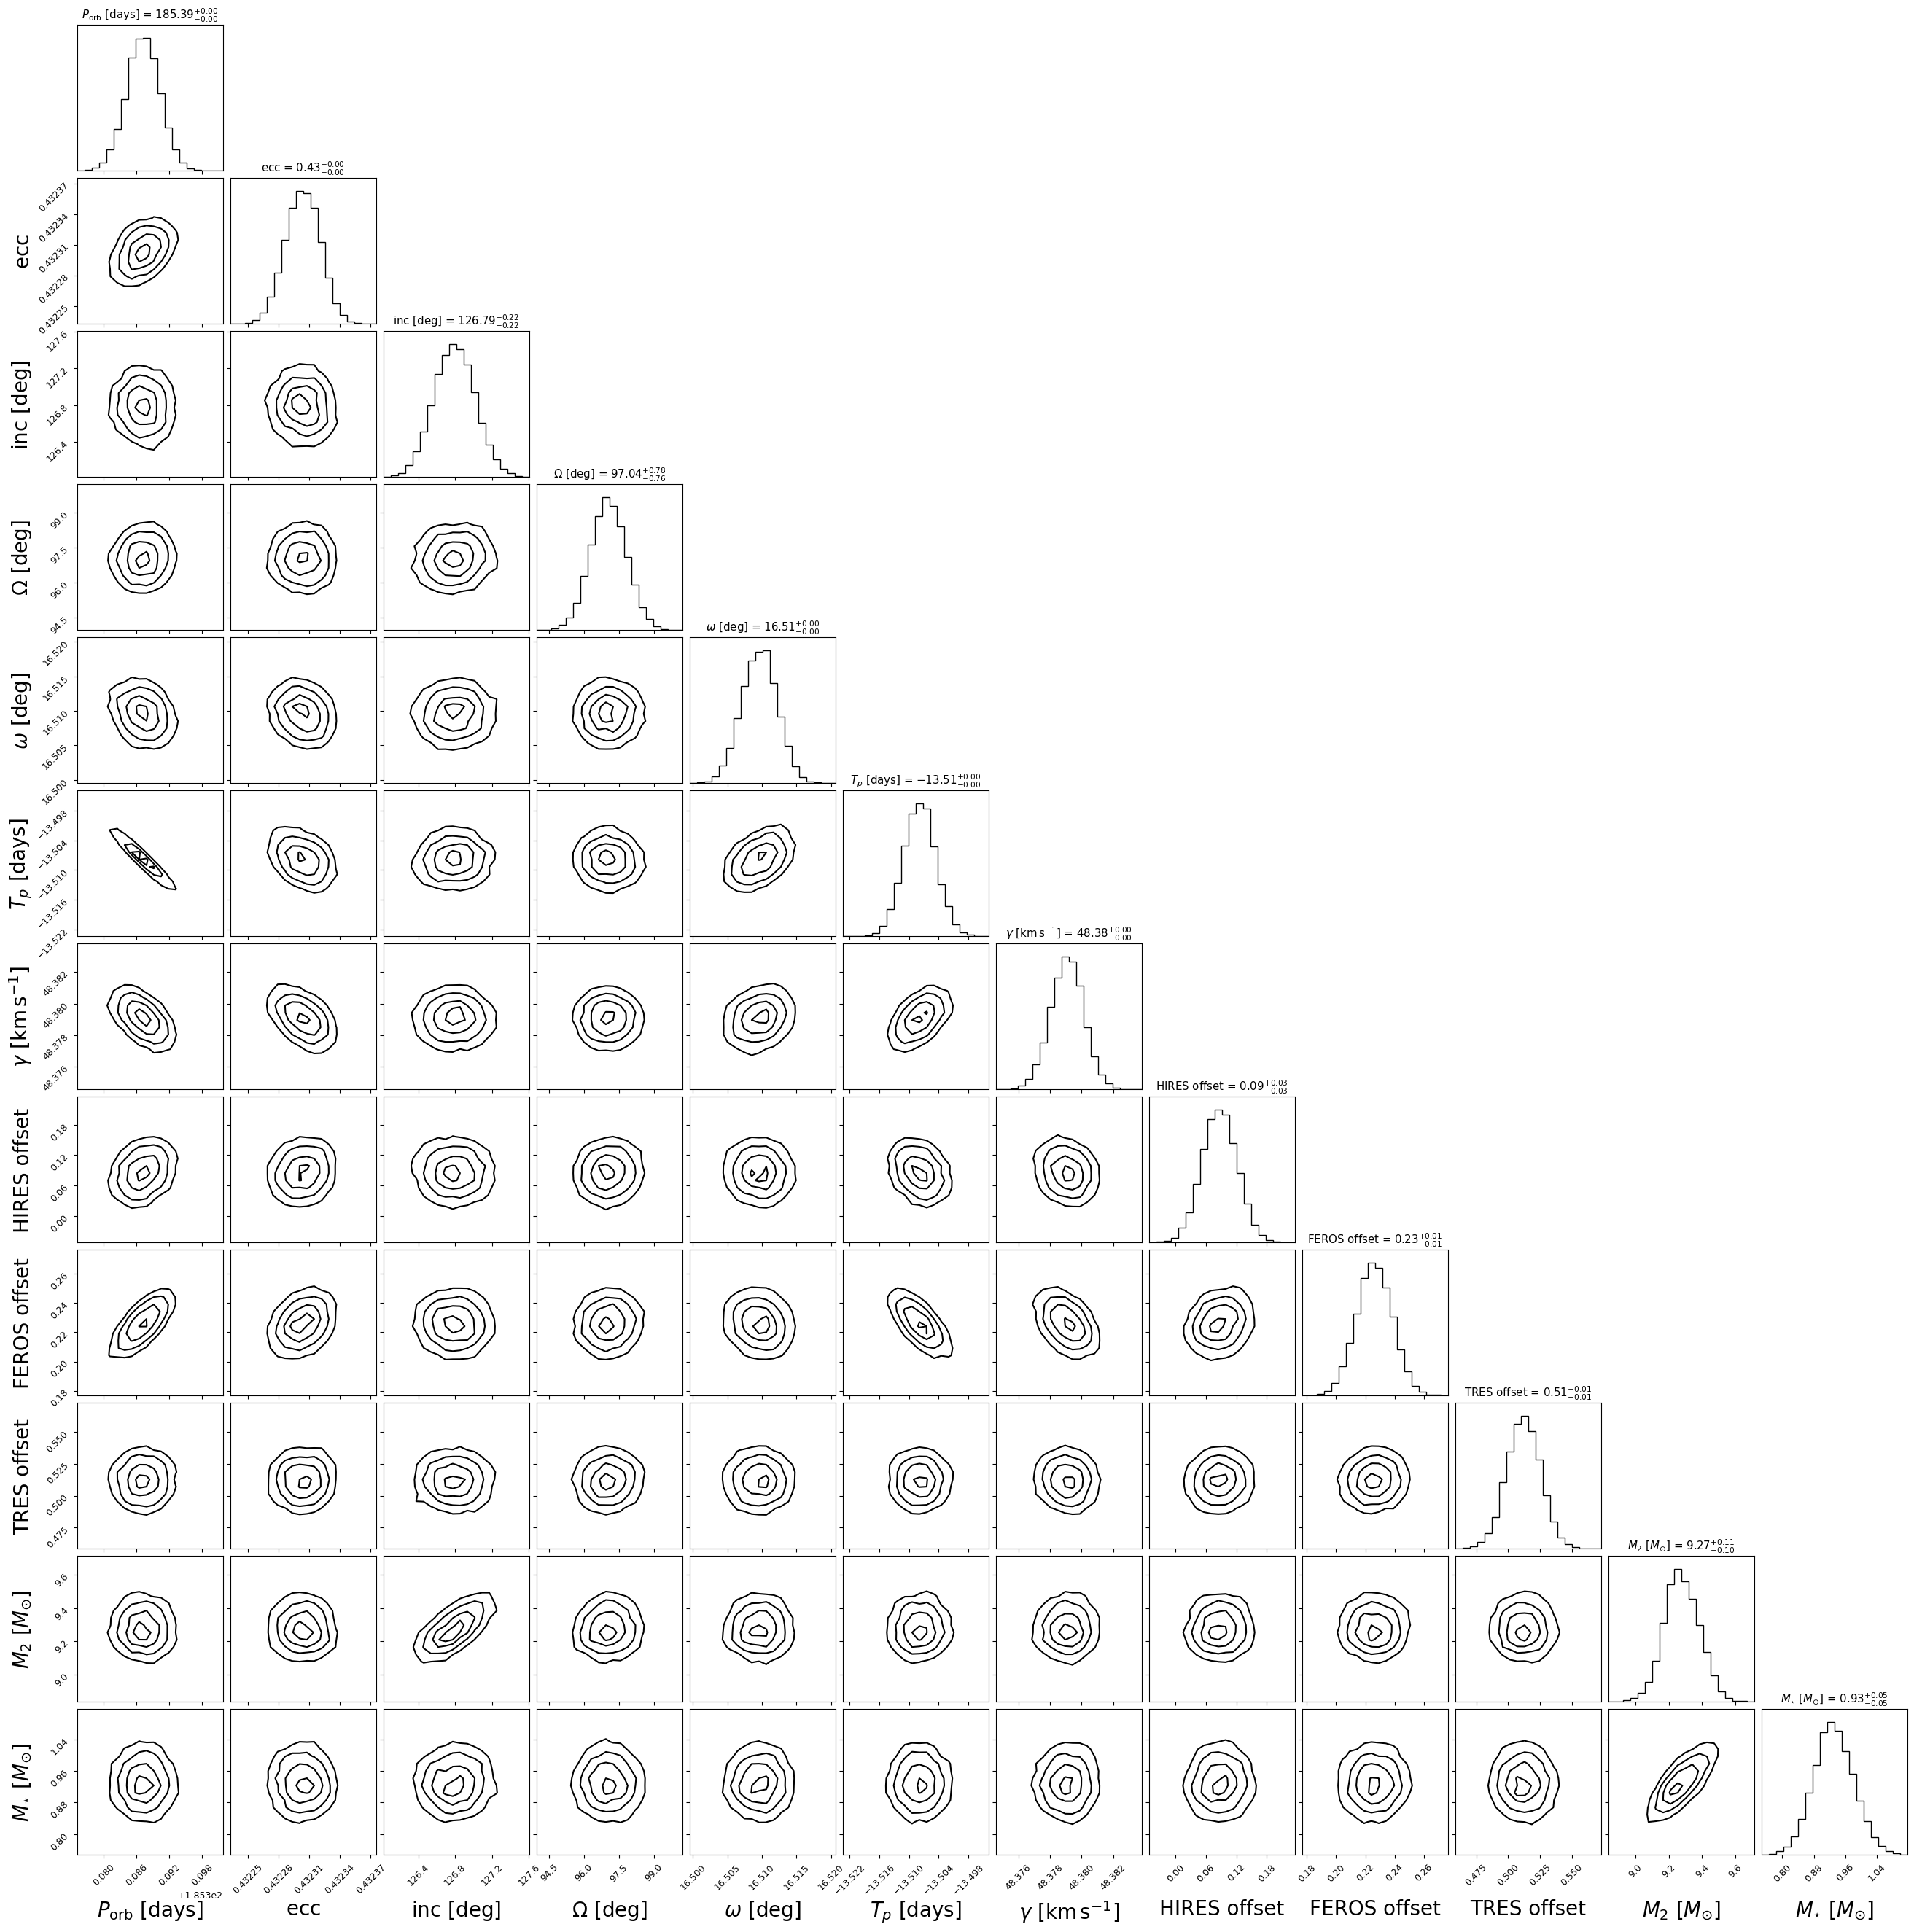

In [18]:
labels = [r'$P_{\rm orb}\,\,[\rm days]$', r'$\rm ecc$', r'$\rm inc\,\,[\rm deg]$', r'$\Omega\,\,[\rm deg]$', 
          r'$\omega\,\,[\rm deg]$', r'$T_{p}\,\,[\rm days]$', r'$\gamma\,\,[\rm km\,s^{-1}]$', 
          r'HIRES offset', r'FEROS offset', r'TRES offset', r'$M_2\,\,[M_{\odot}]$', r'$M_{\star}\,\,[M_{\odot}]$']

_ = corner.corner(sampler.flatchain, labels = labels, show_titles = True, plot_datapoints = False, 
                  plot_density = False, color = 'k', label_kwargs = {'fontsize': 20})   

In [19]:
# Best-fit two-body solution

(period, ecc, inc_deg, omega_deg, w_deg, t_peri, v_com, h_offset, f_offset, t_offset, m2, m1) = sampler.flatchain.T

two_body_MAP = np.array([1.85386858e+02,  4.32298836e-01,  1.26831994e+02,  9.68738877e+01,
                         1.65098226e+01, -1.35074970e+01,  4.83787258e+01,  7.41081252e-02,
                         2.26594883e-01,  5.16126943e-01,  9.29383881e+00,  9.32752127e-01])

max_h_offset, max_f_offset, max_t_offset = two_body_MAP[-5], two_body_MAP[-4], two_body_MAP[-3]

Kstar_MAP = get_Kstar_kms(period = two_body_MAP[0], ecc = two_body_MAP[1], inc_deg = two_body_MAP[2], 
                          m1 = two_body_MAP[-1], m2 = two_body_MAP[-2])

frvpred_MAP = get_radial_velocities(t = full_jds_BH1 - jd_ref, P = two_body_MAP[0], T_p = two_body_MAP[5], 
                                    ecc = two_body_MAP[1], K = Kstar_MAP, omega = (np.pi / 180) * two_body_MAP[4], 
                                    gamma = two_body_MAP[-6])

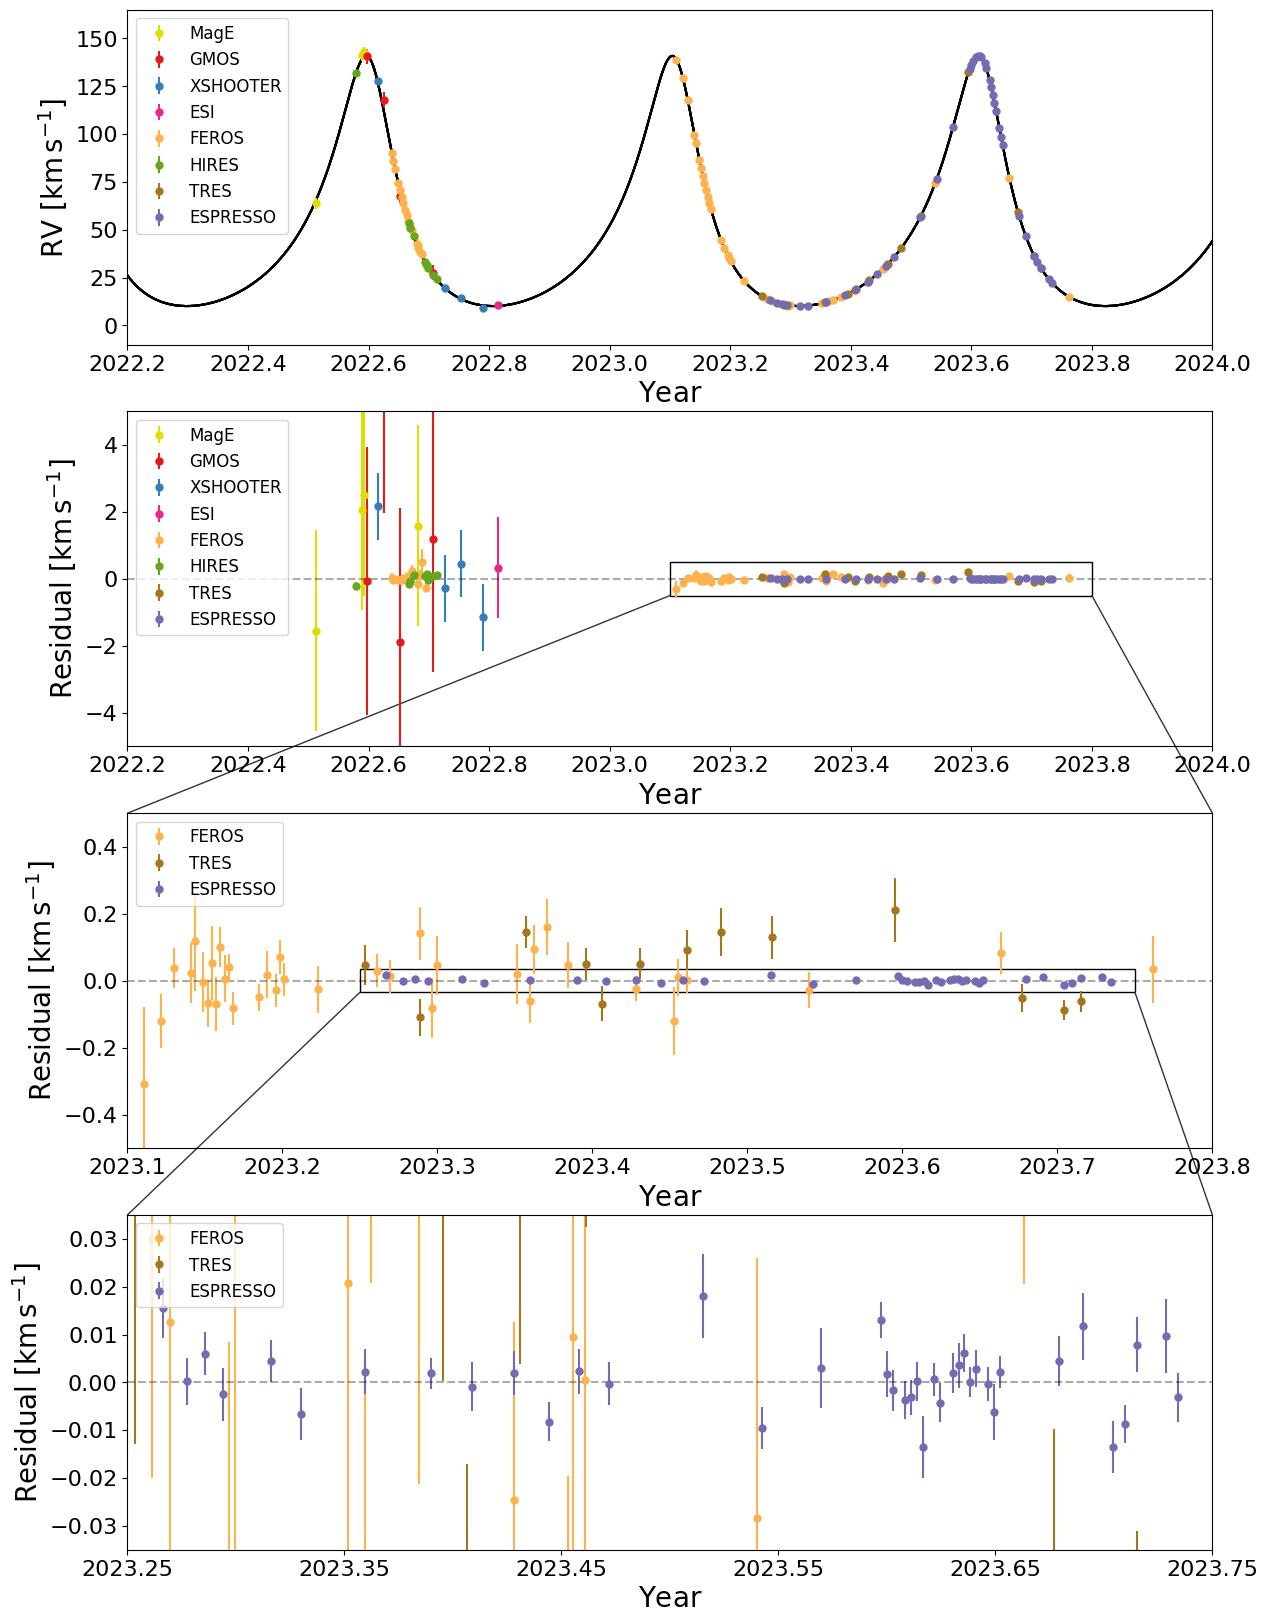

In [20]:
# Plot the best-fit Keplerian RV curve for Gaia BH1

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from astropy.time import Time


def custom_mark_inset(axA, axB, fc='None', ec='k'):
    xx = axB.get_xlim()
    yy = axB.get_ylim()
    xy = (xx[0], yy[0])
    width = xx[1] - xx[0]
    height = yy[1] - yy[0]
    pp = axA.add_patch(patches.Rectangle(xy, width, height, fc=fc, ec=ec))
    p1 = axA.add_patch(patches.ConnectionPatch(
        xyA=(xx[0], yy[0]), xyB=(xx[0], yy[1]),
        coordsA='data', coordsB='data',
        axesA=axA, axesB=axB, linewidth=1, color='0.2'))
    p2 = axA.add_patch(patches.ConnectionPatch(
        xyA=(xx[1], yy[0]), xyB=(xx[1], yy[1]),
        coordsA='data', coordsB='data',
        axesA=axA, axesB=axB,linewidth=1,  color='0.2'))
    return pp, p1, p2


t_grid = np.linspace(np.min(full_jds_BH1) - 150, np.max(full_jds_BH1) + 150, 3000)
randints = np.random.randint(0, len(period), 50)

colors = ['#dede00', '#e41a1c', '#377eb8', '#e7298a', '#feb24c', '#66a61e',  '#a6761d', '#756bb1', '#999999']

residual_astro_fig, ax = plt.subplots(4, 1, figsize = (14, 20))
plt.subplots_adjust(hspace=0.2)
for i in randints:
    Kstar_kms = get_Kstar_kms(period = period[i], inc_deg = inc_deg[i], m1 = m1[i], m2 = m2[i], ecc = ecc[i])
    rv_pred = get_radial_velocities(t = t_grid-jd_ref, P = period[i], T_p = t_peri[i], ecc = ecc[i], K = Kstar_kms,
                                    omega = w_deg[i] * np.pi / 180, gamma = v_com[i])  
    ax[0].plot(Time(t_grid, format= 'jd').decimalyear, rv_pred, 'k', alpha=0.1, rasterized=True)

for i, name in enumerate(['MagE', 'GMOS', 'XSHOOTER', 'ESI', 'FEROS', 'HIRES', 'TRES', 'ESPRESSO']):
    m = full_rv_names_BH1 == name
    if name == 'FEROS':
        rvs_offset = max_f_offset
    elif name == 'HIRES':
        rvs_offset = max_h_offset
    elif name == 'TRES':
        rvs_offset = max_t_offset
    elif name == 'KPF':
        rvs_offset = -0.181277047
    else:
        rvs_offset = 0
    ax[0].errorbar(Time(full_jds_BH1[m], format='jd').decimalyear, full_rvs_BH1[m] - rvs_offset, 
                   yerr = full_rv_errs_BH1[m], fmt ='o', color = colors[i], label = name)
    ax[1].errorbar(Time(full_jds_BH1[m], format='jd').decimalyear, full_rvs_BH1[m] - rvs_offset - frvpred_MAP[m], 
                   yerr = full_rv_errs_BH1[m], fmt ='o', color = colors[i], label = name)
    if name in ['FEROS', 'TRES', 'ESPRESSO']:
        ax[2].errorbar(Time(full_jds_BH1[m], format='jd').decimalyear, 
                       full_rvs_BH1[m] - rvs_offset - frvpred_MAP[m], 
                       yerr = full_rv_errs_BH1[m], fmt ='o', color = colors[i], label = name)
        ax[3].errorbar(Time(full_jds_BH1[m], format='jd').decimalyear, 
                       full_rvs_BH1[m] - rvs_offset - frvpred_MAP[m], 
                       yerr = full_rv_errs_BH1[m], fmt ='o', color = colors[i], label = name)

ax[0].set_xlabel(r'$\rm Year$', fontsize=20)
ax[0].set_ylabel(r'$\rm RV\,\,[\rm km\,s^{-1}]$', fontsize=20)
ax[0].legend(loc = 'upper left', fontsize = 12)
ax[0].set_xlim(2022.2, 2024)
ax[0].set_ylim(-10, 165)
    
ax[1].set_xlim(2022.2, 2024)
ax[1].set_xticks([2022.2, 2022.4, 2022.6, 2022.8, 2023.0, 2023.2, 2023.4, 2023.6, 2023.8, 2024.0])
ax[1].set_xticklabels([2022.2, 2022.4, 2022.6, 2022.8, 2023.0, 2023.2, 2023.4, 2023.6, 2023.8, 2024.0])
ax[1].set_ylim(-5.0, 5.0)

ax[2].set_xlim(2023.1, 2023.75)
ax[2].set_xticks([2023.1, 2023.2, 2023.3, 2023.4, 2023.5, 2023.6, 2023.7, 2023.8])
ax[2].set_xticklabels([2023.1, 2023.2, 2023.3, 2023.4, 2023.5, 2023.6, 2023.7, 2023.8])
ax[2].set_ylim(-0.5, 0.5)

ax[3].set_xlim(2023.25, 2023.75)
ax[3].set_xticks([2023.25, 2023.35, 2023.45, 2023.55, 2023.65, 2023.75])
ax[3].set_xticklabels([2023.25, 2023.35, 2023.45, 2023.55, 2023.65, 2023.75])
ax[3].set_ylim(-0.035, 0.035)

for aa in [ax[1], ax[2], ax[3]]:
    aa.set_xlabel(r'$\rm Year$', fontsize=20)
    aa.set_ylabel(r'$\rm Residual\,\,[\rm km\,s^{-1}]$', fontsize=20)
    aa.hlines(0, aa.get_xlim()[0], aa.get_xlim()[1], linestyle = '--', alpha = 0.33, color = 'black')
    aa.legend(loc = 'upper left', fontsize = 12)

for aa in ax:
    aa.tick_params(axis = 'both', which = 'major', labelsize = 16)
    
_ = custom_mark_inset(ax[1], ax[2])
_ = custom_mark_inset(ax[2], ax[3]);

# Hierarchical Triple Model

In [21]:
def setup_simulation(theta, JD_ref = 2460000):
    """Set up a REBOUND simulation of a hierarchical triple."""
    (P_inner, e_inner, i_inner, Omega_inner, omega_inner, Tp_inner, 
     P_outer, e_outer, i_outer, Omega_outer, omega_outer, Tp_outer,
     M_BH_tot, q_inner, M_star, gamma, hires_offset, feros_offset, tres_offset) = theta
    
    sim = rebound.Simulation()
    sim.units = ('days', 'AU', 'Msun')
    sim.t = JD_ref
    
    Tp_inner += JD_ref
    Tp_outer += JD_ref
    
    M_BH1 = M_BH_tot / (1 + q_inner)
    M_BH2 = M_BH_tot - M_BH1
    
    sim.add(m = M_BH1)
    sim.add(m = M_BH2, P = P_inner, e = e_inner, inc = i_inner, Omega = Omega_inner, omega = omega_inner, 
            T = Tp_inner)
    sim.add(m = M_star, P = P_outer, e = e_outer, inc = i_outer, Omega = Omega_outer, omega = omega_outer, 
            T = Tp_outer)
    sim.move_to_com()
    return sim


def run_simulation(simulation, times):
    """Generate simulated hierarchical triple RVs in km/s at specified epochs."""
    RVs = np.zeros(len(times))
    for i, t in enumerate(times):
        simulation.integrate(times[i])
        RVs[i] = 1.73148e3 * simulation.particles[2].vz 
    return RVs

In [22]:
def init_local_Keplerian(JD_ref = 2460000, P_outer = 185.59, Tp_outer = -13.5, e_outer = 0.451, 
                         omega_outer = 12.8 * (np.pi / 180), semi_amplitude = 66700):
    """Initialize a RadVel fit."""
    
    params = radvel.Parameters(1, basis='per tp e w k')
    time_base = JD_ref
    
    params['per1'] = radvel.Parameter(value = P_outer)      
    params['tp1'] = radvel.Parameter(value = JD_ref + Tp_outer)    
    params['e1'] = radvel.Parameter(value = e_outer)        
    params['w1'] = radvel.Parameter(value = omega_outer)        
    params['k1'] = radvel.Parameter(value = semi_amplitude)         
    
    fit_basis = 'per tc secosw sesinw logk'
    fit_params = params.basis.to_any_basis(params, fit_basis) 
    
    mod = radvel.RVModel(fit_params, time_base = time_base)
    mod.params['dvdt'] = radvel.Parameter(value = 0.)
    mod.params['curv'] = radvel.Parameter(value = 0.)
    return mod


def local_Keplerian(times, RVs, RV_err = 2.5, JD_ref = 2460000, P_outer = 185.59, Tp_outer = -13.5, 
                    e_outer = 0.451, omega_outer = 12.8 * (np.pi / 180), method = 'Powell', tol = 1e-5):
    """Fit a RadVel Keplerian model to the data."""
    
    semi_amplitude = 0.5 * 1e3 * (np.max(RVs) - np.min(RVs))
    mod_theory = init_local_Keplerian(JD_ref = JD_ref, P_outer = P_outer, Tp_outer = Tp_outer, e_outer = e_outer, 
                                      omega_outer = omega_outer, semi_amplitude = semi_amplitude)
    
    like_theory = radvel.likelihood.RVLikelihood(mod_theory, times, 1e3 * RVs, RV_err)
    like_theory.params['gamma'] = radvel.Parameter(value = 0.)       
    like_theory.params['jit'] = radvel.Parameter(value = 0.)         

    like_theory.params['dvdt'].vary = False
    like_theory.params['curv'].vary = False
    like_theory.params['gamma'].vary = False
    like_theory.params['jit'].vary = False
    
    post_theory = radvel.posterior.Posterior(like_theory)
    post_theory.priors += [radvel.prior.EccentricityPrior(1)]
    
    theory_linspace = np.linspace(times[0] - 5, times[-1] + 5, 100)
    res_theory = optimize.minimize(post_theory.neglogprob_array, post_theory.get_vary_params(), 
                                   method = method, tol = tol)
    return like_theory


def simulation_pipeline(times, JD_ref = 2460000, P_inner = 6, e_inner = 0.1, i_inner = 30 * (np.pi / 180),
                        Omega_inner = 97.8 * (np.pi / 180), omega_inner = 12.8 * (np.pi / 180), Tp_inner = -1.1, 
                        P_outer = 185.59, e_outer = 0.451, i_outer = 126.6 * (np.pi / 180), 
                        Omega_outer = 97.8 * (np.pi / 180), omega_outer = 12.8 * (np.pi / 180), Tp_outer = -1.1, 
                        M_BH_tot = 9.62, q_inner = 1, M_star = 0.93, RV_err = 2.5):
    """Generate RV residuals for a given hierarchical triple configuration in m/s."""
    
    theta = (P_inner, e_inner, i_inner, Omega_inner, omega_inner, Tp_inner, 
             P_outer, e_outer, i_outer, Omega_outer, omega_outer, Tp_outer,
             M_BH_tot, q_inner, M_star, 46.6, 0, 0, 0)
    
    sim = setup_simulation(theta, JD_ref = JD_ref)
    RVs = run_simulation(sim, times)
    
    like_theory = local_Keplerian(times, RVs, RV_err = RV_err, JD_ref = JD_ref, P_outer = P_outer,
                                  Tp_outer = Tp_outer, e_outer = e_outer, omega_outer = omega_outer, gamma = gamma)
    return like_theory.residuals()

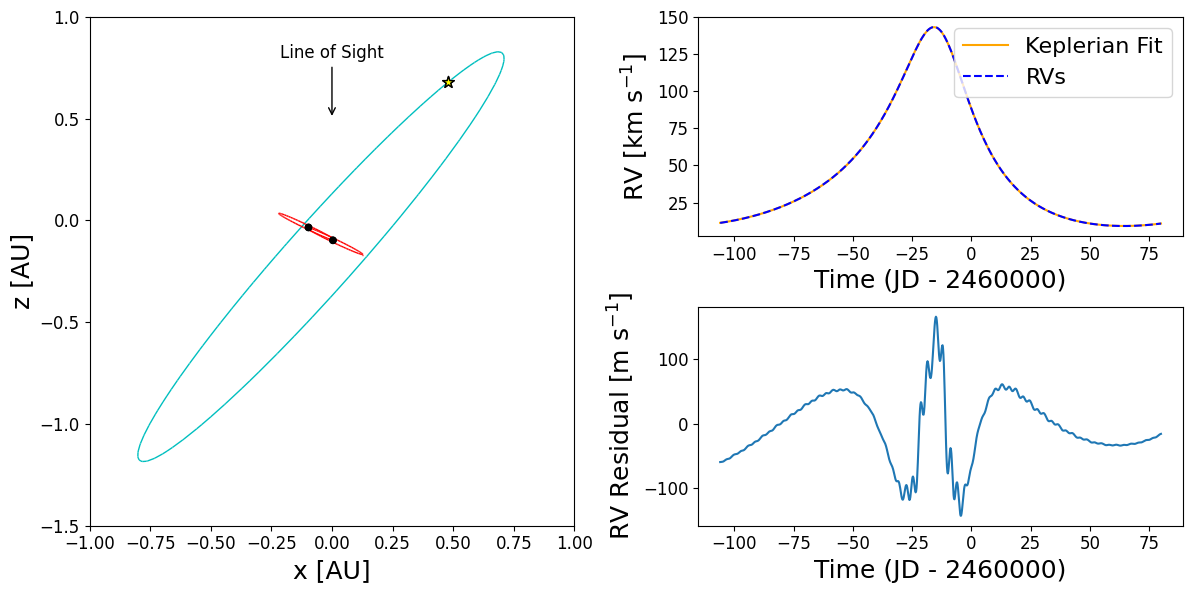

In [23]:
style = dict(linestyle='none', marker='o', ms=3, lw=1, markeredgecolor='k',
             markeredgewidth=0.5, ecolor='k', elinewidth=1, capsize=0.5, label = 'RVs')

intro_times = np.linspace(2460000 - 106, 2460000 + 80, 1000)


def viz_figure(times, JD_ref = 2460000, P_inner = 6, e_inner = 0.1, i_inner = 30 * (np.pi / 180),
               Omega_inner = 97.8 * (np.pi / 180), omega_inner = 12.8 * (np.pi / 180), Tp_inner = -13.5, 
               P_outer = 185.59, e_outer = 0.451, i_outer = 126.6 * (np.pi / 180), 
               Omega_outer = 97.8 * (np.pi / 180), omega_outer = 12.8 * (np.pi / 180), Tp_outer = -13.5, 
               M_BH_tot = 9.62, q_inner = 1, M_star = 0.93, gamma = 46.6, RV_err = 2.5):
    """Visualize a hierarchical triple configuration."""
    
    theta = (P_inner, e_inner, i_inner, Omega_inner, omega_inner, Tp_inner, 
             P_outer, e_outer, i_outer, Omega_outer, omega_outer, Tp_outer,
             M_BH_tot, q_inner, M_star, gamma, 0, 0, 0)
    
    intro_sim = setup_simulation(theta, JD_ref = JD_ref)
    RVs = run_simulation(intro_sim, times)
    
    RV_likelihood = local_Keplerian(times, RVs, RV_err = RV_err, JD_ref = JD_ref, P_outer = P_outer,
                                    Tp_outer = Tp_outer, e_outer = e_outer, omega_outer = omega_outer)
        
    intro_figure = plt.figure(figsize = (12, 6))

    gs = intro_figure.add_gridspec(2, 2)
    ax1 = intro_figure.add_subplot(gs[0, 1])
    ax2 = intro_figure.add_subplot(gs[1, 1], sharex = ax1)
    ax3 = intro_figure.add_subplot(gs[:, 0])
    
    ax1.plot(times - 2460000, gamma + 1e-3 * RV_likelihood.model(times), label = 'Keplerian Fit', color = 'orange')
    ax1.plot(times - 2460000, gamma + RVs, linestyle = '--', label = 'RVs', color = 'blue')
    ax1.set_xlabel('Time (JD - 2460000)', size = 18)
    ax1.set_ylabel(r'RV [km s$^{-1}$]', size = 18)
    ax1.tick_params(axis = 'both', labelsize = 12)
    ax1.legend(fontsize = 16)
    
    ax2.plot(times - 2460000, RV_likelihood.residuals())
    ax2.set_xlabel('Time (JD - 2460000)', size = 18)
    ax2.set_ylabel(r'RV Residual [m s$^{-1}$]', size = 18)
    ax2.tick_params(axis = 'both', labelsize = 12)
    
    # Dummy particle for plotting purposes
    intro_sim = setup_simulation(theta, JD_ref = JD_ref)
    intro_sim.add(a = 100, primary = intro_sim.particles[2])
    
    ob1 = rebound.OrbitPlot(intro_sim, projection = 'xz', color = True, particles = [1, 2], show_primary = False, 
                            unitlabel = '[AU]', xlim = (-1.0, 1.0), ylim = (-1.5, 1.0), fig = intro_figure, 
                            ax = ax3, orbit_style = 'solid')
    ob2 = rebound.OrbitPlot(intro_sim, projection = 'xz', color = True, particles = [0], primary = 1, 
                            show_primary = False, fig = ob1.fig, ax = ob1.ax, orbit_style = 'solid')
    ob3 = rebound.OrbitPlot(intro_sim, projection = 'xz', color = False, particles = [3], primary = 2, 
                            orbit_style = None, fig = ob2.fig, ax = ob2.ax)
    ob1.ax.set_xlabel('x [AU]', size = 18)
    ob1.ax.set_ylabel('z [AU]', size = 18)
    ob1.particles.set_sizes([20, 0, 0, 0])
    ob2.particles.set_sizes([20, 0, 0, 0])
    ob3.primary.set_sizes([75])
    ob3.primary.set_color('yellow')
    ob3.primary.set_edgecolor('black')
    ob1.ax.tick_params(axis = 'both', labelsize = 12)
    ax3.annotate('Line of Sight', xy = (0, 0.5), xytext = (0, 0.8), horizontalalignment = 'center',
                 arrowprops = dict(arrowstyle = "->"), fontsize = 12)

    intro_figure.tight_layout()
    return intro_figure


intro_figure = viz_figure(intro_times)

In [24]:
# Simulated cadence with focus around periastron

def gen_realistic_times(JD_ref = 2460000, time_shift = -121):
    before = np.linspace(0, 90, 18)
    during = np.linspace(95, 115, 14)
    after = np.linspace(120, 200, 18)
    times = np.concatenate([before, during, after])
    times += JD_ref + time_shift
    return times
    
    
realistic_times = gen_realistic_times()

In [25]:
def reduced_chi_squared(actual, obs, obs_err, num_params = 7):
    """Calculate reduced chi-squared metric."""
    scaled_resid = (actual - obs) / obs_err
    dof = len(obs) - num_params
    return np.sum(scaled_resid ** 2) / dof

100%|█████████████████████████████████████████| 150/150 [00:08<00:00, 18.33it/s]


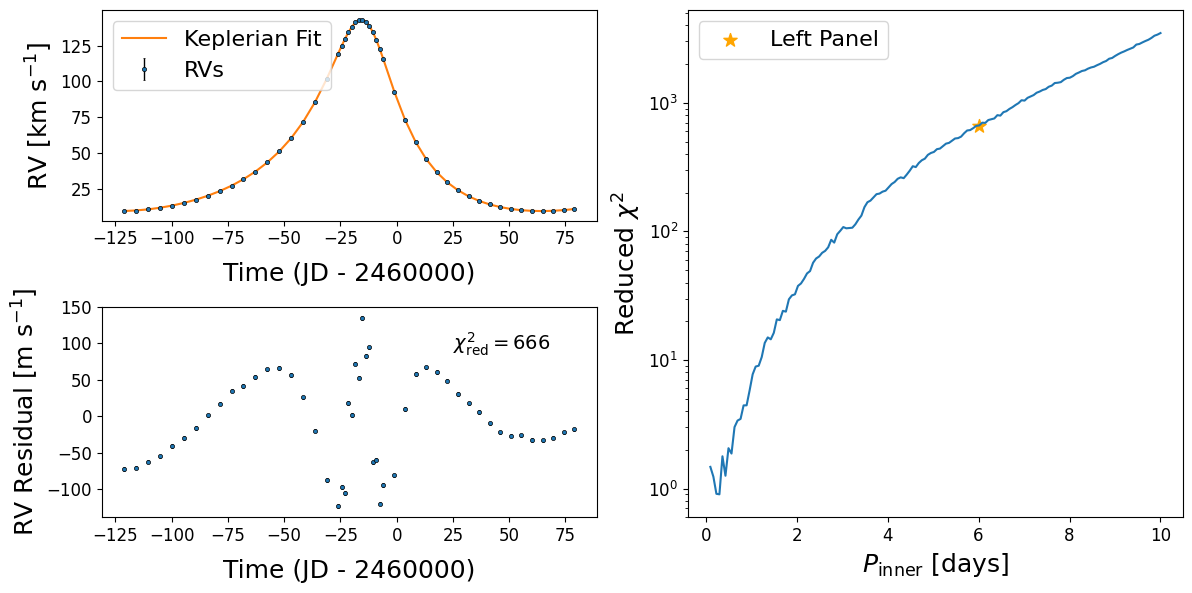

In [26]:
chi_periods = np.linspace(0.1, 10, 150)

def realistic_figure(times, JD_ref = 2460000, P_inner = 6, e_inner = 0.1, i_inner = 30 * (np.pi / 180),
                     Omega_inner = 97.8 * (np.pi / 180), omega_inner = 12.8 * (np.pi / 180), Tp_inner = -13.5, 
                     P_outer = 185.59, e_outer = 0.451, i_outer = 126.6 * (np.pi / 180), 
                     Omega_outer = 97.8 * (np.pi / 180), omega_outer = 12.8 * (np.pi / 180), Tp_outer = -13.5, 
                     M_BH_tot = 9.62, q_inner = 1, M_star = 0.93, gamma = 46.6, RV_err = 2.5):
    """Visualize a realistic RV sampling paradigm."""
    
    theta = (P_inner, e_inner, i_inner, Omega_inner, omega_inner, Tp_inner, 
             P_outer, e_outer, i_outer, Omega_outer, omega_outer, Tp_outer,
             M_BH_tot, q_inner, M_star, gamma, 0, 0, 0)
    
    realistic_sim = setup_simulation(theta, JD_ref = JD_ref)
    RVs = run_simulation(realistic_sim, times)
    RVs += np.random.normal(size = len(RVs), scale = RV_err * 1e-3)
    
    RV_likelihood = local_Keplerian(times, RVs, RV_err = RV_err, JD_ref = JD_ref, P_outer = P_outer,
                                    Tp_outer = Tp_outer, e_outer = e_outer, omega_outer = omega_outer)
    residuals = RV_likelihood.residuals()
    
    realistic_fig = plt.figure(figsize = (12, 6))
    gs = realistic_fig.add_gridspec(2, 2)
    ax1 = realistic_fig.add_subplot(gs[0, 0])
    ax2 = realistic_fig.add_subplot(gs[1, 0], sharex = ax1)
    ax3 = realistic_fig.add_subplot(gs[:, 1])
    
    ax1.errorbar(times - 2460000, gamma + RVs, yerr = 2.5 * 1e-3, **style)
    ax1.plot(times - 2460000, gamma + 1e-3 * RV_likelihood.model(times), label = 'Keplerian Fit')
    ax1.set_xlabel('Time (JD - 2460000)', size = 18, labelpad = 10)
    ax1.set_ylabel(r'RV [km s$^{-1}$]', size = 18)
    ax1.tick_params(axis = 'both', labelsize = 12)
    ax1.legend(fontsize = 16)
   
    ax2.errorbar(times - 2460000, residuals, yerr = 2.5, **style)
    ax2.set_xlabel('Time (JD - 2460000)', size = 18, labelpad = 10)
    ax2.set_ylabel(r'RV Residual [m s$^{-1}$]', size = 18)
    ax2.tick_params(axis = 'both', labelsize = 12)
    
    chis = []
    for binary_period in tqdm(chi_periods):
        theta = (binary_period, e_inner, i_inner, Omega_inner, omega_inner, Tp_inner,
                 P_outer, e_outer, i_outer, Omega_outer, omega_outer, Tp_outer,
                 M_BH_tot, q_inner, M_star, gamma, 0, 0, 0)
    
        sim = setup_simulation(theta, JD_ref = JD_ref)
        RVs = run_simulation(sim, times)
        RVs += np.random.normal(size = len(RVs), scale = RV_err * 1e-3)
        likelihood = local_Keplerian(times, RVs, RV_err = RV_err, JD_ref = JD_ref, P_outer = P_outer,
                                     Tp_outer = Tp_outer, e_outer = e_outer, omega_outer = omega_outer)
        chis.append(reduced_chi_squared(likelihood.model(times), 1e3 * RVs, 2.5))
    chis = np.array(chis)

    chi_interpf = interp1d(chi_periods, chis)
    curr_chi = float(chi_interpf(P_inner))
    ax2.text(25, 90, r'$\chi^2_{\mathrm{red}} = ' + f'{round(curr_chi)}$', fontsize = 14)

    ax3.semilogy(chi_periods, chis)
    ax3.set_xlabel(r'$P_{\mathrm{inner}}$ [days]', size = 18)
    ax3.set_ylabel(r'Reduced $\chi^2$', size = 18)
    ax3.tick_params(axis = 'both', labelsize = 12)
    ax3.scatter(P_inner, curr_chi, marker = "*", s = 100, color = 'orange', label = 'Left Panel')
    ax3.legend(fontsize = 16)
    
    realistic_fig.tight_layout()
    return realistic_fig


realistic_fig = realistic_figure(realistic_times)

In [27]:
# Prior and Likelihood for emcee sampler

def gaussian_prior(val, mu, sigma):
    """Gaussian prior distribution, used for mass of luminous star."""
    prefactor = np.log(1.0 / (np.sqrt(2 * np.pi) * sigma))
    exponential = -0.5 * (val - mu) ** 2 / sigma ** 2
    return prefactor + exponential


def log_prior(theta):
    """Use priors to enforce physical values for orbital parameters."""
    (P_inner, e_inner, i_inner, Omega_inner, omega_inner, Tp_inner, 
     P_outer, e_outer, i_outer, Omega_outer, omega_outer, Tp_outer, 
     M_BH_tot, q_inner, M_star, gamma, hires_offset, feros_offset, tres_offset) = theta
    if (P_inner >= 0.5 and 0 <= e_inner <= 1 and 0 <= Omega_inner <= 2 * np.pi and 0 <= omega_inner <= 2 * np.pi 
        and 0 <= i_inner <= np.pi and P_outer > 0 and 0 <= e_outer <= 1 and 0 <= Omega_outer <= 2 * np.pi 
        and 0 <= omega_outer <= 2 * np.pi and 0 <= i_outer <= np.pi and M_BH_tot >= 0 and q_inner <= 1 
        and M_star > 0 and abs(gamma - 50) <= 50):
        return gaussian_prior(M_star, 0.93, 0.05)
    return -np.inf


def update_ln_likelihood(theta, ll):
    """Calculate astrometric term of log likelihood."""
    (P_inner, e_inner, i_inner, Omega_inner, omega_inner, Tp_inner, 
     P_outer, e_outer, inc, omega, w, Tp_outer,
     M_BH_tot, q_inner, M_star, gamma, hires_offset, feros_offset, tres_offset) = theta
    a0_mas = get_a0_mas(period = P_outer, m1 = M_star, m2 = M_BH_tot, parallax = 2.0954515888832432)
    A_pred = a0_mas * (np.cos(w) * np.cos(omega) - np.sin(w) * np.sin(omega) * np.cos(inc))
    B_pred = a0_mas * (np.cos(w) * np.sin(omega) + np.sin(w) * np.cos(omega) * np.cos(inc))
    F_pred = -a0_mas * (np.sin(w) * np.cos(omega) + np.cos(w) * np.sin(omega) * np.cos(inc))
    G_pred = -a0_mas * (np.sin(w) * np.sin(omega) - np.cos(w) * np.cos(omega) * np.cos(inc))
    num_cycles = np.floor((jd_ref - jd_ref_gaia) / P_outer)
    t_peri_gaia = Tp_outer + jd_ref - jd_ref_gaia - num_cycles * P_outer
    y_vec = np.array([A_pred, B_pred, F_pred, G_pred, e_outer, P_outer, t_peri_gaia])
    ll += lnL_with_covariance(y_vec = y_vec, mu_vec = mu_vec_BH1_short, Sigma_mat = cov_mat_BH1_short)
    return ll


def ln_likelihood(theta, times, RVs, RV_errs, RV_names, JD_ref = 2460000):
    """Total log likelihood with RV and astrometric terms."""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    sim = setup_simulation(theta, JD_ref = JD_ref)
    RVs_test = run_simulation(sim, times)
    RVs_sim = theta[-4] + RVs_test
    RVs_sim = update_offsets(RVs_sim, RV_names, theta[-3], theta[-2], theta[-1])
    ll = -0.5 * np.sum((RVs - RVs_sim) ** 2 / RV_errs ** 2)
    ll = update_ln_likelihood(theta, ll)
    return lp + ll

In [28]:
# Prior for dynesty sampler

def prior_transform(u):
        """Transforms the uniform random variables `u ~ Unif[0., 1.)`
        to the parameters of interest."""

        x = np.zeros(len(u))
        
        # P_inner
        m, s = 1, 1e4  
        low, high = 0.5, 2.5 
        low_n, high_n = (low - m) / s, (high - m) / s  
        x[0] = scipy.stats.truncnorm.ppf(u[0], low_n, high_n, loc=m, scale=s)
        
        # e_inner
        m, s = 0.3, 1e4  
        low, high = 0.001, 0.99
        low_n, high_n = (low - m) / s, (high - m) / s
        x[1] = scipy.stats.truncnorm.ppf(u[1], low_n, high_n, loc=m, scale=s)
    
        # Omega_inner
        m, s = np.pi, 1e4
        low, high = 0, 2 * np.pi 
        low_n, high_n = (low - m) / s, (high - m) / s
        x[2] = scipy.stats.truncnorm.ppf(u[2], low_n, high_n, loc=m, scale=s)
        
        # omega_inner
        m, s = np.pi, 1e4
        low, high = 0, 2 * np.pi 
        low_n, high_n = (low - m) / s, (high - m) / s
        x[3] = scipy.stats.truncnorm.ppf(u[3], low_n, high_n, loc=m, scale=s)

        # i_inner
        m, s = np.pi/2, 1e4
        low, high = 0, np.pi
        low_n, high_n = (low - m) / s, (high - m) / s
        x[4] = scipy.stats.truncnorm.ppf(u[4], low_n, high_n, loc=m, scale=s)
        
        # Tp_inner
        m, s = 2, 1e4
        low, high = -2.5, 2.5
        low_n, high_n = (low - m) / s, (high - m) / s
        x[5] = scipy.stats.truncnorm.ppf(u[5], low_n, high_n, loc=m, scale=s)
        
        # P_outer
        m, s = 185.4, 1e4
        low, high = 185.3, 185.5
        low_n, high_n = (low - m) / s, (high - m) / s
        x[6] = scipy.stats.truncnorm.ppf(u[6], low_n, high_n, loc=m, scale=s)
        
        # e_outer
        m, s = 0.4322, 1e4
        low, high = 0.4320, 0.4325
        low_n, high_n = (low - m) / s, (high - m) / s
        x[7] = scipy.stats.truncnorm.ppf(u[7], low_n, high_n, loc=m, scale=s)
        
        # omega_outer
        m, s = 1.69, 1e4
        low, high = 1.60, 1.75
        low_n, high_n = (low - m) / s, (high - m) / s
        x[8] = scipy.stats.truncnorm.ppf(u[8], low_n, high_n, loc=m, scale=s)
        
        # w_outer
        m, s = 0.288, 1e4
        low, high = 0.287, 0.289
        low_n, high_n = (low - m) / s, (high - m) / s
        x[9] = scipy.stats.truncnorm.ppf(u[9], low_n, high_n, loc=m, scale=s)
        
        # inc
        m, s = 2.214, 1e4
        low, high = 2.19, 2.23
        low_n, high_n = (low - m) / s, (high - m) / s
        x[10] = scipy.stats.truncnorm.ppf(u[10], low_n, high_n, loc=m, scale=s)
        
        # Tp_outer
        m, s = -13.51, 1e4
        low, high = -13.53, -13.49
        low_n, high_n = (low - m) / s, (high - m) / s
        x[11] = scipy.stats.truncnorm.ppf(u[11], low_n, high_n, loc=m, scale=s)
        
        # M_BH_tot
        m, s = 9.31, 1e4
        low, high = 8.9, 9.7
        low_n, high_n = (low - m) / s, (high - m) / s
        x[12] = scipy.stats.truncnorm.ppf(u[12], low_n, high_n, loc=m, scale=s)
        
        # q_inner
        m, s = 0.9, 1e4
        low, high = 0.001, 0.999
        low_n, high_n = (low - m) / s, (high - m) / s
        x[13] = scipy.stats.truncnorm.ppf(u[13], low_n, high_n, loc=m, scale=s)
        
        # M_star
        m, s = 0.93, 0.05
        low, high = 0.8, 1.05
        low_n, high_n = (low - m) / s, (high - m) / s
        x[14] = scipy.stats.truncnorm.ppf(u[14], low_n, high_n, loc=m, scale=s)
        
        # gamma
        m, s = 48.38, 1
        low, high = 48.373, 48.385
        low_n, high_n = (low - m) / s, (high - m) / s
        x[15] = scipy.stats.truncnorm.ppf(u[15], low_n, high_n, loc=m, scale=s)
        
        # hires_offset
        m, s = 0.08, 1
        low, high = -0.2, 0.3
        low_n, high_n = (low - m) / s, (high - m) / s
        x[16] = scipy.stats.truncnorm.ppf(u[16], low_n, high_n, loc=m, scale=s)
        
        # feros_offset
        m, s = 0.22, 1
        low, high = 0.16, 0.28
        low_n, high_n = (low - m) / s, (high - m) / s
        x[17] = scipy.stats.truncnorm.ppf(u[17], low_n, high_n, loc=m, scale=s)
        
        # tres_offset
        m, s = 0.51, 1
        low, high = 0.4, 0.6
        low_n, high_n = (low - m) / s, (high - m) / s
        x[18] = scipy.stats.truncnorm.ppf(u[18], low_n, high_n, loc=m, scale=s)
        return x

In [29]:
# Generate discrete predictions from two-body model for comparison

Kstar_two_body = get_Kstar_kms(period = two_body_MAP[0], ecc = two_body_MAP[1], inc_deg = two_body_MAP[2], 
                               m1 = two_body_MAP[-1], m2 = two_body_MAP[-2])

rvpred_two_body = get_radial_velocities(t = jds_BH1 - jd_ref, P = two_body_MAP[0], T_p = two_body_MAP[5], 
                                        ecc = two_body_MAP[1], K = Kstar_two_body, 
                                        omega = (np.pi / 180) * two_body_MAP[4], gamma = two_body_MAP[-6])

print(log_likelihood(two_body_MAP))

-94.42170180817187


In [30]:
# Generate continuous predictions from two-body model for comparison

three_body_linspace = np.linspace(Time(2023.25, format = 'decimalyear').jd, 
                                  Time(2023.75, format = 'decimalyear').jd, 1000)

rvpred_two_body_continuous = get_radial_velocities(t = three_body_linspace - jd_ref, P = two_body_MAP[0], 
                                                   T_p = two_body_MAP[5], ecc = two_body_MAP[1], 
                                                   K = Kstar_two_body, omega = (np.pi / 180) * two_body_MAP[4], 
                                                   gamma = two_body_MAP[-6])

In [31]:
# Maximum probability three-body solution

three_body_MAP = np.array([9.80493409e-01,  2.04964371e-01,  1.89911258e+00,  3.00886264e+00,  
                           1.13402477e-01, -7.01904622e-01,  1.85459360e+02,  4.32449540e-01,
                           2.21051241e+00,  1.71416874e+00,  2.88339560e-01, -1.35048784e+01,
                           9.23510932e+00,  7.98980821e-01,  9.33683471e-01,  4.83746877e+01,
                           1.01120337e-01,  2.24266620e-01,  5.24503196e-01])

ln_likelihood(three_body_MAP, jds_BH1, rvs_BH1, rv_errs_BH1, rv_names_BH1)

-81.91354359312844

In [32]:
# Generate discrete and continuous predictions from three-body model for comparison

three_body_sim = setup_simulation(three_body_MAP)

rvpred_three_body = 4.83748318e+01 + run_simulation(three_body_sim, jds_BH1)
rvpred_continuous = 4.83748318e+01 + run_simulation(three_body_sim, three_body_linspace)

In [33]:
def BIC(sample_size, num_params, log_likelihood):
    """Definition of Bayesian Information Criterion for model selection."""
    return num_params * np.log(sample_size) - 2 * log_likelihood

def BIC_two_body(theta):
    """Calculate BIC value for a two-body model."""
    (period, ecc, inc_deg, omega_deg, w_deg, t_peri, v_com, h_offset, f_offset, t_offset, M_BH, M_star) = theta 
    inc, omega, w = inc_deg * np.pi/180, omega_deg * np.pi/180, w_deg * np.pi/180
    
    Kstar_kms = get_Kstar_kms(period = period, inc_deg = inc_deg, m1 = M_star, m2 = M_BH, ecc = ecc)
    rv_pred = get_radial_velocities(t = jds_BH1 - jd_ref, P = period, T_p = t_peri, ecc = ecc, 
                                    K = Kstar_kms, omega = w, gamma = v_com)
    rv_pred = update_offsets(rv_pred, rv_names_BH1, h_offset, f_offset, t_offset)
    lnL = -0.5 * np.sum((rv_pred - rvs_BH1) ** 2 / rv_errs_BH1 ** 2)
    lnL = update_log_likelihood(theta, lnL)
    return BIC(len(rvs_BH1), len(theta), lnL)

def BIC_three_body(theta):
    """Calculate BIC value for a three-body model."""
    sim = setup_simulation(theta, JD_ref = 2460000)
    RVs_test = run_simulation(sim, jds_BH1)
    RVs_sim = theta[-4] + RVs_test
    RVs_sim = update_offsets(RVs_sim, rv_names_BH1, theta[-3], theta[-2], theta[-1])
    ll = -0.5 * np.sum((rvs_BH1 - RVs_sim) ** 2 / rv_errs_BH1 ** 2)
    ll = update_ln_likelihood(theta, ll)
    return BIC(len(rvs_BH1), len(theta), ll)

print(BIC_two_body(two_body_MAP), BIC_three_body(three_body_MAP))

245.7795594754931 258.1289579224141


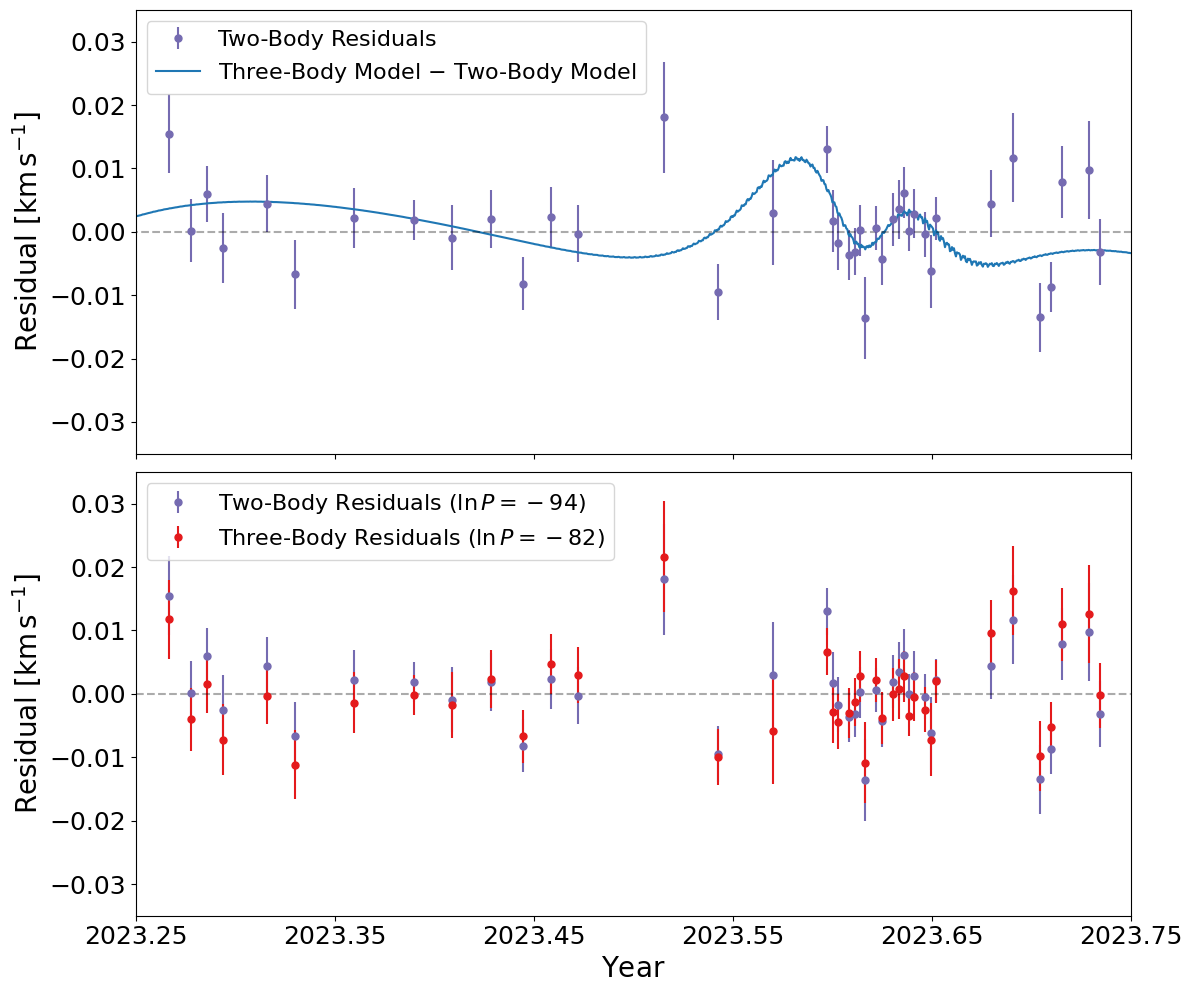

In [34]:
# Plot for comparison of residuals of best-fit two-body and three-body RV models

full_models_fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10), sharex = True, sharey = True, 
                                          tight_layout = True)

three_body_plotspace = np.array([Time(t, format = 'jd').decimalyear for t in three_body_linspace])

m = rv_names_BH1 == 'ESPRESSO'
ax1.errorbar(Time(jds_BH1[m], format='jd').decimalyear, rvs_BH1[m] - rvpred_two_body[m], 
             yerr = rv_errs_BH1[m], fmt ='o', color = '#756bb1', label = 'Two-Body Residuals')
ax1.plot(three_body_plotspace, rvpred_continuous - rvpred_two_body_continuous, 
         label = r'Three-Body Model $-$ Two-Body Model')
ax1.set_ylabel(r'$\rm Residual\,\,[\rm km\,s^{-1}]$', fontsize = 20)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax1.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle = '--', alpha = 0.33, color = 'black')
handles, labels = ax1.get_legend_handles_labels()
order = [1, 0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'upper left', fontsize = 16)

ax2.errorbar(Time(jds_BH1[m], format='jd').decimalyear, rvs_BH1[m] - rvpred_two_body[m], 
             yerr = rv_errs_BH1[m], fmt ='o', color = '#756bb1', 
             label = 'Two-Body Residuals' + r' ($\ln{P} = -94$)')
ax2.errorbar(Time(jds_BH1[m], format='jd').decimalyear, rvs_BH1[m] - rvpred_three_body[m], 
             yerr = rv_errs_BH1[m], fmt ='o', color = '#e41a1c', 
             label = 'Three-Body Residuals' + r' ($\ln{P} = -82$)')
ax2.set_xlim(2023.25, 2023.75)
ax2.set_ylim(-0.035, 0.035)
ax2.set_xticks([2023.25, 2023.35, 2023.45, 2023.55, 2023.65, 2023.75])
ax2.set_xticklabels([2023.25, 2023.35, 2023.45, 2023.55, 2023.65, 2023.75])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax2.set_xlabel(r'$\rm Year$', fontsize = 20)
ax2.set_ylabel(r'$\rm Residual\,\,[\rm km\,s^{-1}]$', fontsize=20)
ax2.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyle = '--', alpha = 0.33, color = 'black')
ax2.legend(loc = 'upper left', fontsize = 16);